In [1]:
import streamlit as st
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df= pd.read_csv("boxing_data_raw.csv",
                header = None, 
                names = ['Rank','Name','empty1','Weight Class','Record','Age','empty2','Location'],
                usecols=['Rank','Name','Weight Class','Record','Age','Location'],
                skip_blank_lines = True)
df.dropna(how = 'all',inplace=True)
df.head()

In [38]:
# Turn 'record' into 3 columns for wins, losses and draws
record_split = df.Record.str.split(expand = True).rename(columns = {0:'Wins',1:'Losses',2:'Draws'})
df = pd.concat([df, record_split], axis = 1)

# Get rid of hashtag for rank so it cna be converted to a number
df.Rank = df.Rank.str.replace('#','', regex=False)

# Clean names
df.Name = df.Name.str.replace('*','', regex=False)

df = df.astype({'Rank': 'int32', 
                'Wins': 'int32',
                'Losses': 'int32',
                'Draws': 'int32',
                "Age":'float32'})


df.loc[:,'Total Fights'] = df.loc[:,['Wins','Losses','Draws']].sum(axis = 1)
df.loc[:,'Win Percentage'] = ((df.loc[:,'Wins']/df.loc[:,'Total Fights'])*100).round(1)


# Split location down into town/area and country
location_split = df.Location.str.rsplit(expand = True, n=1, pat = ',').rename(columns = {0:'Region',1:'Country'})
# pd.concat([df.Location,location_split], axis = 1 ).sample(20) test code
df = pd.concat([df, location_split], axis = 1)

In [39]:
def findGeocode(area):
    from geopy.exc import GeocoderTimedOut
    from geopy.geocoders import Nominatim
    '''
    Uses geopy to get the location of 
    Geolocator geocodertimedout sometimes throws and exception, so we use a try catch to get around it
    '''
    
    try:
        # Specify the user_agent as your app name it should not be none
        geolocator = Nominatim(user_agent="Richie_boxing_dashboard_side_project")
        return geolocator.geocode(area)
    
    except GeocoderTimedOut:
        return findGeocode(area)	

longitude = []
latitude = []

unique_countries =  df.Country.unique()

for i in (unique_countries):
	
	if findGeocode(i) != None:
		loc = findGeocode(i)
		latitude.append(loc.latitude)
		longitude.append(loc.longitude)
	
	else:
		latitude.append(np.nan)
		longitude.append(np.nan)


In [40]:
countries_lat_long = pd.DataFrame({'Country':unique_countries,'LAT':latitude,'LON':longitude})

df = df.merge(countries_lat_long,how = 'left')
df['LAT'] = df.apply(lambda x: x['LAT'] + np.random.normal(0, 0.5), axis=1)
df['LON'] = df.apply(lambda x: x['LON'] + np.random.normal(0, 0.5), axis=1)

df.head()

,Rank,Name,Weight Class,Record,Age,Location,Wins,Losses,Draws,Total Fights,Win Percentage,Region,Country,LAT,LON
0,1,Saul Alvarez,super middle,58 2 2,32.0,"Guadalajara, Jalisco, Mexico",58,2,2,62,93.5,"Guadalajara, Jalisco",Mexico,24.130750,-102.031701
1,2,Tyson Fury,heavy,33 0 1,34.0,"Morecambe, Lancashire, United Kingdom",33,0,1,34,97.1,"Morecambe, Lancashire",United Kingdom,54.646769,-3.165991
2,3,Dmitrii Bivol,light heavy,21 0 0,31.0,"Indio, California, USA",21,0,0,21,100.0,"Indio, California",USA,39.182937,-100.588612
3,4,Terence Crawford,welter,39 0 0,35.0,"Omaha, Nebraska, USA",39,0,0,39,100.0,"Omaha, Nebraska",USA,40.096247,-100.467049
4,5,Gennadiy Golovkin,middle,42 2 1,40.0,"Los Angeles, California, USA",42,2,1,45,93.3,"Los Angeles, California",USA,39.975398,-100.522195


array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Wins'}>,
        <AxesSubplot: title={'center': 'Losses'}>],
       [<AxesSubplot: title={'center': 'Draws'}>,
        <AxesSubplot: title={'center': 'Total Fights'}>,
        <AxesSubplot: title={'center': 'Win Percentage'}>],
       [<AxesSubplot: title={'center': 'LAT'}>,
        <AxesSubplot: title={'center': 'LON'}>, <AxesSubplot: >]],
      dtype=object)

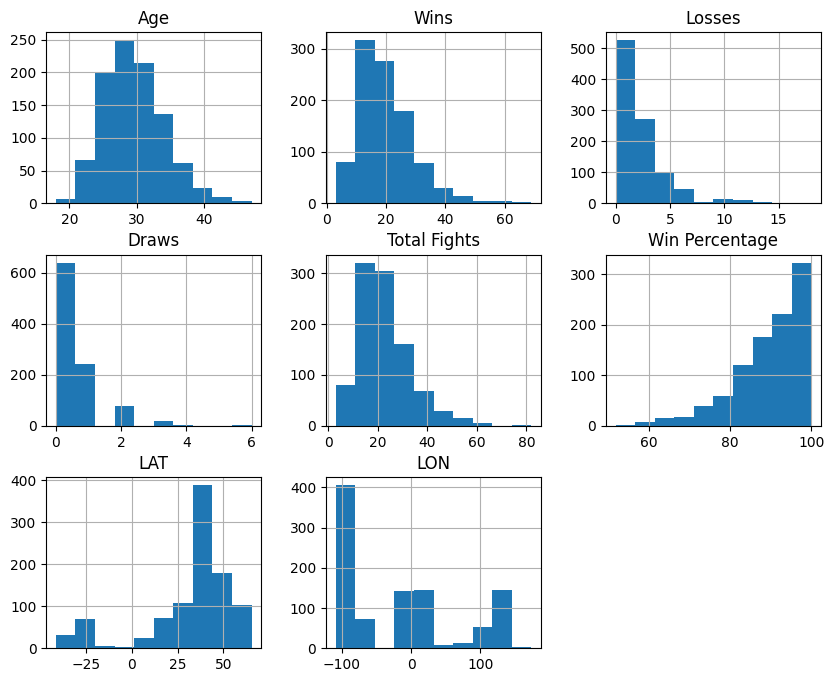

In [41]:
df.drop(columns="Rank",inplace=False).hist(figsize=[10,8])

In [42]:
df.to_csv('boxing_data_cleaned.csv',index = False)